In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
%cd /content/drive/My\ Drive/

In [ ]:
import numpy as np
import gym
from gym import spaces
import random
import collections
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [ ]:
class MultiAgentActionSpace(list):
    def __init__(self, agents_action_space):
        for x in agents_action_space:
            assert isinstance(x, gym.spaces.space.Space)

        super(MultiAgentActionSpace, self).__init__(agents_action_space)
        self._agents_action_space = agents_action_space

    def sample(self):
        """ samples action for each agent from uniform distribution"""
        return [agent_action_space.sample() for agent_action_space in self._agents_action_space]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class MultiAgentObservationSpace(list):
    def __init__(self, agents_observation_space):
        for x in agents_observation_space:
            assert isinstance(x, gym.spaces.space.Space)

        super().__init__(agents_observation_space)
        self._agents_observation_space = agents_observation_space

    def sample(self):
        """ samples observations for each agent from uniform distribution"""
        return [agent_observation_space.sample() for agent_observation_space in self._agents_observation_space]

    def contains(self, obs):
        """ contains observation """
        for space, ob in zip(self._agents_observation_space, obs):
            if not space.contains(ob):
                return False
        else:
            return True

In [ ]:
class Grid(gym.Env):
    metadata = {'render.modes': ['console']}
    # action id
    XM = 0 # x minus
    XP = 1 # x plus
    YM = 2 # y minus
    YP = 3 # y plus

    def __init__(self, x_size, y_size, n_agents=2, fov_x=3, fov_y=3):
        super(Grid, self).__init__()

        # size of 2D grid
        self.x_size = x_size
        self.y_size = y_size

        # number of agents
        self.n_agents = n_agents
        self.idx_agents = list(range(n_agents)) # [0, 1, 2, ..., n_agents - 1]

        # initialize the mapping status
        self.init_grid()

        # initialize the position of the agent
        self.init_agent()

        # define action space
        n_actions = 4 # LEFT, RIGHT, TOP, BOTTOM
        self.action_space = MultiAgentActionSpace([spaces.Discrete(n_actions) for _ in range(self.n_agents)])

        # define observation space (fielf of view)
        self.fov_x = fov_x # number of cells around the agent
        self.fov_y = fov_y # number of cells around the agent

        self.obs_low = -np.ones(4) * 2 # low -2: out of the grid
        self.obs_high = np.ones(4) # high 1: visited
        self.observation_space = MultiAgentObservationSpace([spaces.Box(self.obs_low, self.obs_high) for _ in range(self.n_agents)])

    def init_agent(self, initial_pos=None):
        self.agent_pos = []
        if initial_pos is not None:
            self.agent_pos = initial_pos
            for i in range(self.n_agents):
                self.grid_status[self.agent_pos[i][0], self.agent_pos[i][1]] = 1
        else:
            for i in range(self.n_agents):
                agent_pos_x = random.randrange(0, self.x_size)
                agent_pos_y = random.randrange(0, self.x_size)
                self.agent_pos.append([agent_pos_x, agent_pos_y])
                self.grid_status[self.agent_pos[i][0], self.agent_pos[i][1]] = 1

        # iniqialize the stuck count
        self.stuck_counts = [0] * self.n_agents

    def init_grid(self):
        # initialize the mapping status
        ## -2: out of the grid
        ## -1: obstacle
        ## 0: POI that is not mapped
        ## 1: POI that is mapped
        self.grid_status = np.zeros([self.x_size, self.y_size])
        self.grid_counts = np.zeros([self.x_size, self.y_size])

        ## randomly set obstacles
        # n_obstacle = random.randrange(0, self.x_size * self.x_size * 0.2) # at most 20% of the grid
        n_obstacle = 0
        for i in range(n_obstacle):
            x_obstacle = random.randrange(1, self.x_size - 1)
            y_obstacle = random.randrange(1, self.y_size - 1)
            self.grid_status[x_obstacle, y_obstacle] = - 1
            self.grid_counts[x_obstacle, y_obstacle] = - 1

        # number of POI in the environment (0)
        self.n_poi = self.x_size * self.y_size - np.count_nonzero(self.grid_status)

    def get_coverage(self):
        mapped_poi = (self.grid_status == 1).sum()
        return mapped_poi / self.n_poi

    def get_agent_obs(self):
        self.agent_obs = []

        # observation for each agent
        for agent in range(self.n_agents):
            # default: out of the grid
            single_obs = -np.ones([self.fov_x, self.fov_y]) * 2
            for i in range(self.fov_x): # 0, 1, 2
                for j in range(self.fov_y): # 0, 1, 2
                    obs_x = self.agent_pos[agent][0] + (i - 1) # -1, 0, 1
                    obs_y = self.agent_pos[agent][1] + (j - 1) # -1, 0, 1
                    if obs_x >= 0 and obs_y >= 0 and obs_x <= self.x_size - 1 and obs_y <= self.y_size - 1:
                        single_obs[i][j] = copy.deepcopy(self.grid_status[obs_x][obs_y])
            single_obs_flat = single_obs.flatten() # convert matrix to list
            # extract the necessary cells
            xm = single_obs_flat[1]
            xp = single_obs_flat[7]
            ym = single_obs_flat[3]
            yp = single_obs_flat[5]
            single_obs_flat = np.array([xm, xp, ym, yp])
            self.agent_obs.append(single_obs_flat)
        return self.agent_obs

    def reset(self, initial_pos=None):
        # initialize the mapping status
        self.init_grid()
        # initialize the position of the agent
        self.init_agent(initial_pos)

        # check if the drones at initial positions are surrounded by obstacles
        while True:
            obs = self.get_agent_obs()
            obs_tf = []
            for i in range(self.n_agents):
                agent_obs_tf = obs[i][0] != 0 and obs[i][1] != 0 and obs[i][2] != 0 and obs[i][3] != 0
                obs_tf.append(agent_obs_tf)
            if any(obs_tf):
                self.init_grid()
                self.init_agent()
            else:
                break

        return self.get_agent_obs()

    def step(self, action, i): # i: index of the drone
        # original position
        org_x  = copy.deepcopy(self.agent_pos[i][0])
        org_y  = copy.deepcopy(self.agent_pos[i][1])

        # move the agent
        if action == self.XM:
            self.agent_pos[i][0] -= 1
        elif action == self.XP:
            self.agent_pos[i][0] += 1
        elif action == self.YM:
            self.agent_pos[i][1] -= 1
        elif action == self.YP:
            self.agent_pos[i][1] += 1
        else:
            raise ValueError("Received invalid action={} which is not part of the action space".format(action))

        # account for the boundaries of the grid (-2: out of the grid)
        if self.agent_pos[i][0] > self.x_size - 1 or self.agent_pos[i][0] < 0 or self.agent_pos[i][1] > self.y_size - 1 or self.agent_pos[i][1] < 0:
            self.agent_pos[i][0] = org_x
            self.agent_pos[i][1] = org_y
            self.grid_counts[self.agent_pos[i][0], self.agent_pos[i][1]] += 1
            reward = 0
        else:
            # previous status of the cell
            prev_status = self.grid_status[self.agent_pos[i][0], self.agent_pos[i][1]]
            if prev_status == -1: # the new position is on the obstacle
                # go back to the original position
                self.agent_pos[i][0] = org_x
                self.agent_pos[i][1] = org_y
                self.grid_counts[self.agent_pos[i][0], self.agent_pos[i][1]] += 1
                reward = 0
            elif prev_status == 0:
                self.grid_counts[self.agent_pos[i][0], self.agent_pos[i][1]] += 1
                self.grid_status[self.agent_pos[i][0], self.agent_pos[i][1]] = 1
                reward = 10
            elif prev_status == 1:
                self.grid_counts[self.agent_pos[i][0], self.agent_pos[i][1]] += 1
                reward = 0

        # update the stuck count
        if org_x == self.agent_pos[i][0] and org_y == self.agent_pos[i][1]: # stuck
            self.stuck_counts[i] += 1
        else:
            self.stuck_counts[i] = 0

        # are we map all cells?
        mapped_poi = (self.grid_status == 1).sum()
        done = bool(mapped_poi == self.n_poi)

        return self.get_agent_obs(), reward, done

    def close(self):
        pass

## **SARSA**

In [ ]:
# multi-agent setting
# each agent has an individual q table

class QTables():
    def __init__(self, observation_space, action_space, eps_start=1, eps_end=0.1, gamma=0.9, r=0.99, lr=0.1):
        self.num_agents = len(observation_space)

        self.observation_space = observation_space
        self.observation_values = [-2, -1, 0, 1]
        self.observation_num = len(self.observation_values) # 3
        self.observation_length = observation_space[0].shape[0] # field of view

        self.action_space = action_space
        self.action_values = [0, 1, 2, 3] # corresponding to the column numbers in q table
        self.action_num = len(self.action_values) # 4

        self.eps = eps_start  # current epsilon
        self.eps_end = eps_end # epsilon lower bound
        self.r = r  # decrement rate of epsilon
        self.gamma = gamma  # discount rate
        self.lr = lr  # learning rate

        self.q_tables = []
        for agent_i in range(self.num_agents):
            self.q_tables.append(np.random.rand(self.observation_num**self.observation_length, self.action_num))

        self.q_table_counts = []
        for agent_i in range(self.num_agents):
            self.q_table_counts.append(np.zeros([self.observation_num**self.observation_length, self.action_num]))

    # support function: convert the fov to the unique row number in the q table
    def obs_to_row(self, obs_array):
        obs_shift = map(lambda x: x + 2, obs_array) # add 1 to each element
        #obs_power = []
        obs_power = [v * (self.observation_num ** i) for i, v in enumerate(obs_shift)] # apply exponentiation to each element
        #print(obs_power)
        #print(type(obs_power))
        sum=0
        #print(len(obs_power))
        for i in range(0,len(obs_power)):
          sum = sum + obs_power[i]
        return sum # return the sum (results are between 0 and 256)

    def softmax(self, a):
        # deal with overflow
        c = np.max(a)
        exp_a = np.exp(a - c)
        sum_exp_a = np.sum(exp_a)
        y = exp_a / sum_exp_a
        return y

    def get_action(self, observations, agent_i, stuck_counts, max_stuck, e_greedy=True, softmax=False):
        # convert the observation to a row number
        obs_row = self.obs_to_row(observations[agent_i])
        if stuck_counts[agent_i] >= max_stuck: # random action to avoid stuck
            action = random.choice(self.action_values)
            greedy = False
            action_value = self.q_tables[agent_i][obs_row][action]
        elif e_greedy: # epsilon greedy for training (e_greedy=True)
            if np.random.rand() < self.eps:
                action = random.choice(self.action_values)
                greedy = False
                action_value = self.q_tables[agent_i][obs_row][action]
            else:
                action = np.argmax(self.q_tables[agent_i][obs_row])
                greedy = True
                action_value = self.q_tables[agent_i][obs_row][action]
        elif softmax: # (e_greedy=False and softmax=True)
            p = self.softmax(self.q_tables[agent_i][obs_row])
            action = np.random.choice(np.arange(self.action_num), p=p)
            greedy = False
            action_value = self.q_tables[agent_i][obs_row][action]
        else: # all greedy choices for testing perfabormance
            action = np.argmax(self.q_tables[agent_i][obs_row])
            greedy = True
            action_value = self.q_tables[agent_i][obs_row][action]

        return action, greedy, action_value

    def update_eps(self):
        # update the epsilon
        if self.eps > self.eps_end: # lower bound
            self.eps *= self.r

    def train(self, obs, obs_next, action, reward, done, agent_i,stuck_counts, max_stuck):
        obs_row = self.obs_to_row(obs[agent_i])
        obs_next_row = self.obs_to_row(obs_next[agent_i])
        act_col = action

        st_cnt = stuck_counts
        mx_st = max_stuck

        q_current = self.q_tables[agent_i][obs_row][act_col] # current q value
        #print("obs_next_row Type:",type(obs_row))
        #print("act_next Type: ", type(act_col))
        act_next, _, _ = self.get_action(observations = obs_next, agent_i=agent_i, stuck_counts=st_cnt, max_stuck=mx_st, e_greedy=True, softmax=False)
        #print("Q-Table: ", self.q_tables)
        #print("obs_next_row Type:",type(obs_next_row))
        #print("act_next Type: ", type(act_next))
        #print(act_next)
        q_next_max = self.q_tables[agent_i][obs_next_row][act_next]
        #q_next_max = np.max(self.q_tables[agent_i][obs_next_row]) # the maximum q value in the next state

        # update the q value
        if done:
            self.q_tables[agent_i][obs_row][act_col] = q_current + self.lr * reward
        else:
            self.q_tables[agent_i][obs_row][act_col] = q_current + self.lr * (reward +  (self.gamma * q_next_max) - q_current)

        # inclement the corresponding count
        self.q_table_counts[agent_i][obs_row][act_col] += 1

#                                             **6x6** 2D-Grid

**2 Drones**

In [ ]:
# ===================================================================================================
# Training: 1 drone
# ===================================================================================================

# records for each episode
time_steps = [] # number of time steps in total
epsilons = [] # epsilon at the end of each episode
greedy = [] # the ratio of greedy choices
coverage = [] # the ratio of visited cells at the end
speed = [] # number of time steps to cover decent amount of cells
sum_q_values = [] # sum of q-values
results_mapping = [] # mapping status
results_count = [] # count status
total_reward = []
total_action_values = []
total_greedy_action_values = []

q_class = []

coverage_threshold = 0.90
max_stuck = 1000

# parameters for training
train_episodes = 10000
max_steps = 10 * 10

# initialize the environment and the q tables
env = Grid(x_size=10, y_size=10, n_agents=2, fov_x=3, fov_y=3)
q = QTables(observation_space=env.observation_space, action_space=env.action_space, eps_start=1, eps_end=0, gamma=0.9, r=0.9999, lr=0.01)

# training
for episode in range(train_episodes):
    state = env.reset()
    state = [arr.astype('int') for arr in state] # convert from float to integer
    eps_tmp = q.eps

    greedy_count = [0] * env.n_agents
    coverage_track = True
    epi_reward = [0] * env.n_agents
    epi_action_value = [0] * env.n_agents
    epi_greedy_action_value = [0] * env.n_agents

    for step in range(max_steps):
        action_order = random.sample(env.idx_agents, env.n_agents) # return a random order of the drone indices
        for agent_i in action_order:
            action, greedy_tf, action_value = q.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
            next_state, reward, done = env.step(action, agent_i)
            next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
            q.train(state, next_state, action, reward, done, agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck)

            epi_reward[agent_i] += reward
            greedy_count[agent_i] += greedy_tf * 1
            epi_action_value[agent_i] += action_value
            epi_greedy_action_value[agent_i] += action_value * greedy_tf

            if done:
                break

            # update the observation
            state = next_state

        # check if decent amoung of cells are visited
        current_coverage = env.get_coverage()
        if current_coverage >= coverage_threshold and coverage_track:
            speed.append(step)
            coverage_track = False

        # check if the task is completed
        if done:
            time_steps.append(step)
            break
        elif step == max_steps - 1:
            time_steps.append(step)
            if coverage_track:
                speed.append(np.nan)

    # record
    time_steps.append(step + 1)
    epsilons.append(eps_tmp)
    coverage.append(env.get_coverage())
    greedy.append(list(map(lambda x: x / (step + 1), greedy_count)))
    sum_q_values.append([q.q_tables[0].sum()])
    results_mapping.append(env.grid_status)
    results_count.append(env.grid_counts)
    total_reward.append(epi_reward)
    total_action_values.append(epi_action_value)
    total_greedy_action_values.append(epi_greedy_action_value)

    if episode % 200 == 0:
        q_class.append(copy.deepcopy(q))

    # update epsilon
    q.update_eps()

    print('//Episode {0}//    Epsilon: {1:.3f},    Steps: {2},    Greedy Choices　(%): {3:.3f},    Coverage (%): {4:.3f},    Steps to Visit {5}% Cells: {6},    Sum of Q-Values: {7:.1f},    Total Reward: {8}'\
          .format(episode+1, eps_tmp, step+1, np.mean(greedy[episode]), coverage[episode], coverage_threshold * 100, speed[episode], sum_q_values[episode][0], np.mean(total_reward[episode])))

Streaming output truncated to the last 5000 lines.
//Episode 5001//    Epsilon: 0.607,    Steps: 100,    Greedy Choices　(%): 0.400,    Coverage (%): 0.870,    Steps to Visit 90.0% Cells: nan,    Sum of Q-Values: 6897.2,    Total Reward: 425.0
//Episode 5002//    Epsilon: 0.606,    Steps: 100,    Greedy Choices　(%): 0.355,    Coverage (%): 0.850,    Steps to Visit 90.0% Cells: nan,    Sum of Q-Values: 6899.0,    Total Reward: 415.0
//Episode 5003//    Epsilon: 0.606,    Steps: 100,    Greedy Choices　(%): 0.330,    Coverage (%): 0.730,    Steps to Visit 90.0% Cells: nan,    Sum of Q-Values: 6899.4,    Total Reward: 355.0
//Episode 5004//    Epsilon: 0.606,    Steps: 100,    Greedy Choices　(%): 0.380,    Coverage (%): 0.690,    Steps to Visit 90.0% Cells: nan,    Sum of Q-Values: 6900.7,    Total Reward: 335.0
//Episode 5005//    Epsilon: 0.606,    Steps: 100,    Greedy Choices　(%): 0.320,    Coverage (%): 0.860,    Steps to Visit 90.0% Cells: nan,    Sum of Q-Values: 6902.2,    Total Rew

In [ ]:
print("Mean coverage in SARSA during training: ",np.mean(coverage))

Mean coverage in SARSA during training:  0.7631650000000001


In [ ]:
print(len(coverage))

10000


In [ ]:
episodes = []
for i in range(0,10000):
  episodes.append(i)

In [ ]:
coverage_new = []
episodes_new = []
for i in range(0,2000):
  if i%10 == 0:
    coverage_new.append(coverage[i])
    episodes_new.append(episodes[i])

In [ ]:
print(len(episodes_new))

200


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


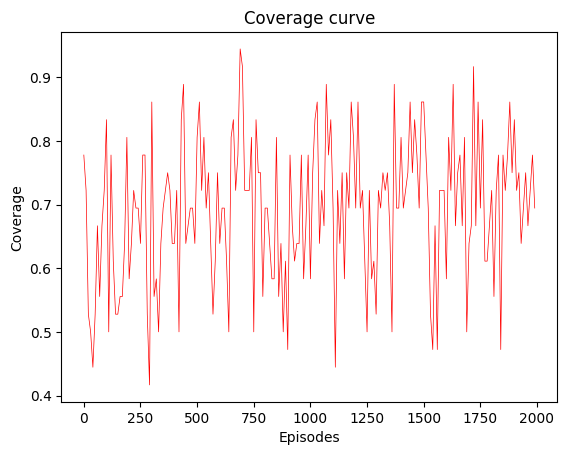

In [ ]:
plt.plot(episodes_new, coverage_new, color='red', linewidth=0.5)
plt.title("Coverage curve")
plt.xlabel("Episodes")
plt.ylabel("Coverage")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


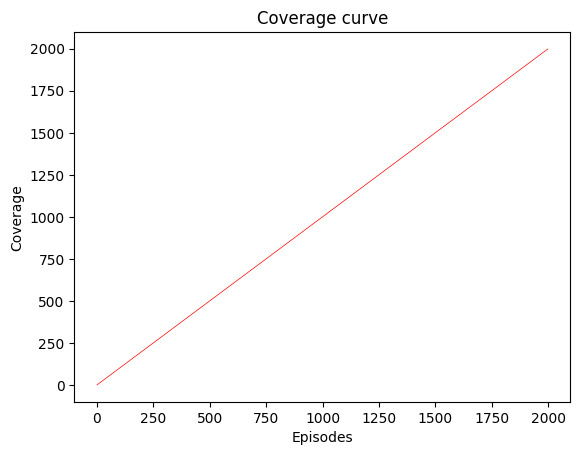

In [ ]:
plt.plot(episodes, episodes, color='red', linewidth=0.5)
plt.title("Coverage curve")
plt.xlabel("Episodes")
plt.ylabel("Coverage")
plt.show()

In [ ]:
#print(len(total_reward))
print(max(total_reward))
print(total_reward)
print(total_reward[951])

[230, 100]
[[90, 120], [110, 100], [80, 150], [160, 30], [70, 140], [90, 90], [70, 100], [100, 100], [80, 130], [60, 120], [130, 160], [80, 140], [90, 60], [150, 130], [90, 120], [150, 120], [40, 140], [70, 140], [90, 150], [130, 100], [50, 150], [120, 160], [90, 40], [150, 90], [60, 130], [130, 110], [120, 100], [60, 110], [90, 110], [120, 100], [130, 60], [150, 70], [60, 100], [100, 180], [70, 150], [90, 160], [70, 160], [120, 90], [130, 70], [140, 80], [110, 110], [140, 120], [50, 150], [160, 60], [100, 90], [60, 40], [130, 130], [70, 70], [150, 70], [80, 180], [120, 90], [90, 170], [150, 110], [140, 60], [110, 130], [140, 120], [70, 100], [70, 120], [70, 110], [80, 110], [70, 150], [170, 100], [100, 140], [50, 170], [60, 80], [130, 70], [110, 30], [210, 30], [90, 80], [70, 120], [50, 170], [130, 120], [70, 110], [120, 120], [110, 90], [130, 60], [90, 140], [50, 70], [160, 60], [140, 80], [100, 80], [60, 110], [40, 140], [60, 140], [180, 80], [100, 120], [60, 180], [160, 50], [140, 

In [ ]:
print(len(time_steps))

4000


In [ ]:
print(np.mean(coverage))

0.7003055555555555


In [ ]:
temp = []
#sum = 0;
for i in range(2000):
  sum = 0;
  for j in range(2):
    sum = sum + total_reward[i][j]

  temp.append(sum)

In [ ]:
print(temp)
print(max(temp))
print(temp.index(max(temp)))

[210, 310, 320, 330, 290, 280, 320, 270, 200, 330, 270, 260, 300, 320, 180, 270, 300, 260, 270, 310, 280, 300, 300, 310, 340, 310, 150, 230, 250, 290, 240, 270, 310, 290, 300, 240, 260, 310, 260, 220, 310, 310, 300, 250, 220, 300, 240, 220, 290, 300, 280, 290, 280, 270, 200, 310, 300, 170, 300, 200, 300, 310, 240, 230, 230, 230, 240, 300, 260, 280, 220, 300, 280, 290, 310, 250, 320, 230, 280, 300, 300, 310, 280, 330, 250, 320, 280, 300, 300, 280, 320, 280, 310, 300, 270, 270, 330, 290, 320, 290, 280, 290, 230, 290, 250, 310, 340, 260, 310, 330, 290, 290, 280, 310, 280, 250, 340, 300, 270, 220, 340, 310, 200, 300, 310, 300, 300, 290, 330, 310, 290, 270, 320, 290, 310, 320, 310, 300, 330, 280, 250, 300, 320, 280, 320, 340, 240, 280, 290, 270, 250, 260, 300, 170, 300, 250, 290, 280, 170, 320, 310, 310, 270, 320, 310, 240, 290, 270, 310, 250, 290, 300, 300, 320, 290, 230, 290, 290, 260, 300, 300, 220, 310, 290, 240, 250, 230, 240, 320, 260, 210, 330, 250, 290, 250, 250, 290, 320, 270, 270,

In [ ]:
q_last = copy.deepcopy(q)

In [ ]:
state = env.reset([[0, 0], [7, 7]])
state = [arr.astype('int') for arr in state]

In [ ]:
print(state[0])

[-2  0 -2  0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
state = env.reset([[0, 0], [9, 9]])
state = [arr.astype('int') for arr in state] # convert from float to integer
q_last.eps = 0
trajectory_1 = [[0, 0]]
trajectory_2 = [[9, 9]]
reward_1 = []
reward_2 = []
action_1 = []
action_2 = []

for step in range(max_steps):
    action_order = [0, 1]
    for agent_i in action_order:
        action, greedy_tf, action_value = q_last.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
        next_state, reward, done = env.step(action, agent_i)
        next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
        if agent_i == 0:
            trajectory_1.append(copy.deepcopy(env.agent_pos[0]))
            reward_1.append(reward)
            action_1.append(action)
        else:
            trajectory_2.append(copy.deepcopy(env.agent_pos[1]))
            reward_2.append(reward)
            action_2.append(action)

        if done:
            break

        # update the observation
        state = next_state

    # check if the task is completed
    if done:
        break

print(step)

99


In [ ]:
print(len(trajectory_1), len(reward_1), len(action_1))

101 100 100


In [ ]:
print(len(trajectory_2), len(reward_2), len(action_2))

101 100 100


In [ ]:
def find_visit(traj,sub_traj):
  flag = 0
  for i in range(len(traj)):
    if(sub_traj == traj[i]):
      flag = 1
  return flag

In [ ]:
trajectory_new1 = []
unique_count1=0
curr_i = 0
visited = []
for i in range(len(trajectory_1)):
  count_i=0
  flag = find_visit(visited, trajectory_1[i])
  if(flag==0):
    unique_count1 = unique_count1 + 1
    trajectory_new1.append(trajectory_1[i])
    for j in range(len(trajectory_1)):
      if(trajectory_1[i]==trajectory_1[j] and i!=j):
      #print(trajectory_2[j])
        count_i = count_i + 1
        #trajectory_new1.append(trajectory_1[i])
    curr_i = curr_i + count_i
    visited.append(trajectory_1[i])
    #if(count_i==0):
      #unique_count2 = unique_count2 + 1

print("No. of unique cells covered by Drone 1: ",unique_count1)
print("No. of repetitions in trajectory of Drone 1: ", curr_i)

No. of unique cells covered by Drone 1:  68
No. of repetitions in trajectory of Drone 1:  33


In [ ]:
trajectory_new2 = []
unique_count2=0
curr_j = 0
visited = []
for i in range(len(trajectory_2)):
  count_i=0
  flag = find_visit(visited, trajectory_2[i])
  if(flag==0):
    unique_count2 = unique_count2 + 1
    trajectory_new2.append(trajectory_2[i])
    for j in range(len(trajectory_2)):
      if(trajectory_2[i]==trajectory_2[j] and i!=j):
      #print(trajectory_2[j])
        count_i = count_i + 1
        #trajectory_new2.append(trajectory_2[i])
    curr_j = curr_j + count_i
    visited.append(trajectory_2[i])
    #if(count_i==0):
      #unique_count2 = unique_count2 + 1

print("No. of unique cells covered by Drone 2: ",unique_count2)
print("No. of repetitions in trajectory of Drone 2: ", curr_j)

No. of unique cells covered by Drone 2:  26
No. of repetitions in trajectory of Drone 2:  75


In [ ]:
print(len(trajectory_new1))
print(len(trajectory_new2))

68
26


No. of Collisions


In [ ]:
print((unique_count1/len(trajectory_1)))
print((unique_count2/len(trajectory_2)))

0.6732673267326733
0.25742574257425743


In [ ]:
rept_list=[]
for i in trajectory_new1:
  if i in trajectory_new2:
    rept_list.append(i)


In [ ]:
print(len(rept_list))

3


In [ ]:
res_list = []
for i in range(len(trajectory_1)):
  for j in range(len(trajectory_2)):
    if(trajectory_1[i]==trajectory_2[j] and i==j):
      res_list.append(trajectory_1[i])

In [ ]:
print("No. of Coliisions: ", len(res_list))

No. of Coliisions:  0


In [ ]:
num_collisions = len(res_list)

In [ ]:
print(unique_count1)
print(unique_count2)

68
26


**Coverage**

In [ ]:
matrix_ele = []
temp = []
for i in range(10):
  for j in range(10):
    temp.append(i)
    temp.append(j)
    matrix_ele.append(temp)
    temp = []

print(matrix_ele)

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [7, 0], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 7], [7, 8], [7, 9], [8, 0], [8, 1], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 8], [8, 9], [9, 0], [9, 1], [9, 2], [9, 3], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9]]


In [ ]:
count_ele1 = 0

for i in range(len(matrix_ele)):
  for j in range(len(trajectory_1)):
    if(matrix_ele[i]==trajectory_1[j]):
      count_ele1 = count_ele1 + 1
      break

coverage1 = count_ele1/100.0

print("No. of Cells coverderd by drone 1: ",count_ele1)
print("Coverage of drone1: ",coverage1)

No. of Cells coverderd by drone 1:  68
Coverage of drone1:  0.68


In [ ]:
count_ele2 = 0

for i in range(len(matrix_ele)):
  for j in range(len(trajectory_2)):
    if(matrix_ele[i]==trajectory_2[j]):
      count_ele2 = count_ele2 + 1
      break

coverage2 = count_ele2/100.0

print("No. of Cells coverderd by drone 2: ",count_ele2)
print("Coverage of drone2: ",coverage2)

No. of Cells coverderd by drone 2:  26
Coverage of drone2:  0.26


In [ ]:
mean_coverage = (count_ele1 + count_ele2)/100.0

print("Mean coverage of both the drones: ",mean_coverage)

Mean coverage of both the drones:  0.94


**Union of cells covered by both drones**

In [ ]:
union_of_cells = unique_count1 + unique_count2 - len(rept_list)
print(union_of_cells)

91


In [ ]:
mean_coverage = union_of_cells/100.0
print("Mean Coverage of both drones: ", mean_coverage)

Mean Coverage of both drones:  0.91


In [ ]:
print(res_list)

[[2, 1]]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
import pandas as pd

In [ ]:
df_traj1 = pd.DataFrame(trajectory_1, columns=['drone_1_x','drone_1_y'], dtype=int)
df_traj2 = pd.DataFrame(trajectory_2, columns=['drone_2_x','drone_2_y'], dtype=int)

In [ ]:
print(len(df_traj1))
print(len(df_traj2))

37
37


In [ ]:
print(df_traj1.loc[19,:])

drone_1_x    5
drone_1_y    4
Name: 19, dtype: int64


In [ ]:
print(df_traj2.loc[19,:])

drone_2_x    2
drone_2_y    3
Name: 19, dtype: int64


In [ ]:
df_traj2.loc[len(df_traj2.index)] = [ 2, 3]

In [ ]:
df = pd.concat([df_traj1, df_traj2], axis=1, join='inner')
print(df.head())

   drone_1_x  drone_1_y  drone_2_x  drone_2_y
0          0          0          9          9
1          1          0          8          9
2          1          1          8          8
3          1          2          8          7
4          1          3          8          6


In [ ]:
print(df_traj1)

    drone_1_x  drone_1_y
0           0          0
1           1          0
2           1          1
3           1          2
4           1          3
5           1          4
6           1          5
7           0          5
8           0          4
9           0          3
10          0          2
11          0          1
12          1          1
13          2          1
14          2          2
15          3          2
16          3          3
17          3          4
18          3          5
19          2          5
20          2          4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(df_traj2)

    drone_2_x  drone_2_y
0           5          5
1           4          5
2           4          4
3           5          4
4           5          3
5           4          3
6           4          2
7           5          2
8           5          1
9           4          1
10          4          0
11          5          0
12          5          1
13          4          1
14          3          1
15          3          0
16          2          0
17          2          1
18          2          2
19          2          3
20          2          3


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
max_steps = 101

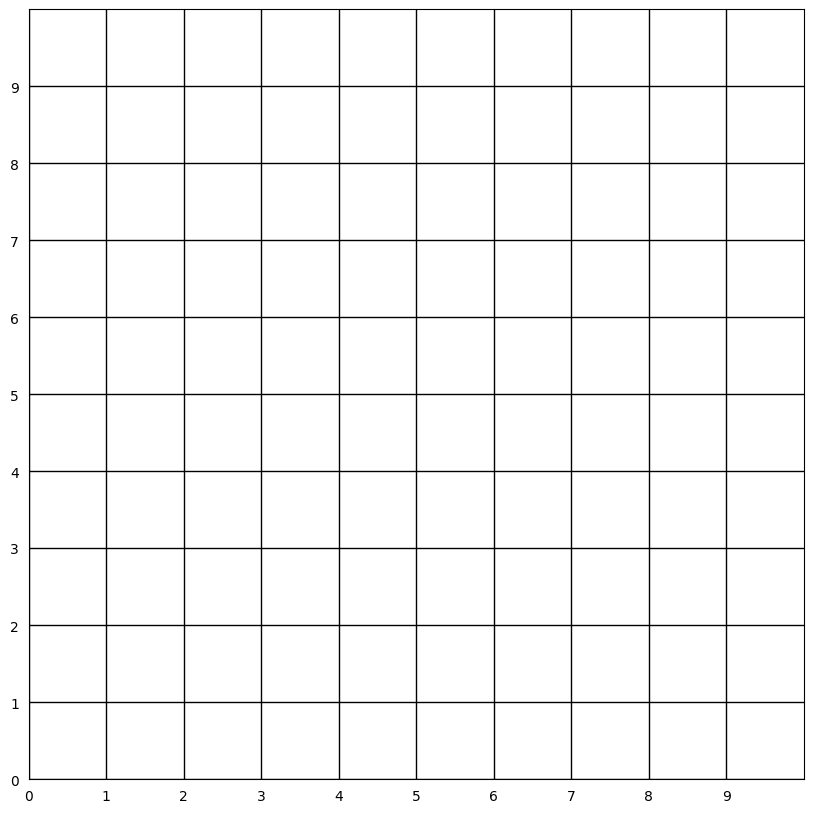

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.set_xlim((0, 10))
ax.set_ylim((0, 10))

# grid
col_labels = range(10)
row_labels = range(10)
ax.set_xticks(range(10))
ax.set_yticks(range(10))
plt.tick_params(labelbottom=col_labels, labelleft=row_labels)
plt.tick_params(color='white')
plt.grid(color='black', linestyle='-', linewidth=1)

def init():
    # initialize an empty list of cirlces
    return []

def animate(i):
    #i = i+2
    frame_patches = []
    # mapping status
    for j in range(i):
        m1 = patches.Rectangle(xy=(df['drone_1_y'][j], 9-df['drone_1_x'][j]), width=1, height=1, fc='lightblue')
        m2 = patches.Rectangle(xy=(df['drone_2_y'][j], 9-df['drone_2_x'][j]), width=1, height=1, fc='darkseagreen')
        frame_patches.append(ax.add_patch(m1))
        frame_patches.append(ax.add_patch(m2))

    # drones
    d1 = patches.Circle(xy=(df['drone_1_y'][i] + 0.25, 9-df['drone_1_x'][i] + 0.25), radius=0.125, fc='steelblue')
    d2 = patches.Circle(xy=(df['drone_2_y'][i] + 0.25, 9-df['drone_2_x'][i] + 0.25), radius=0.125, fc='darkolivegreen')
    m1 = patches.Rectangle(xy=(df['drone_1_y'][i], 9-df['drone_1_x'][i]), width=1, height=1, fc='lightblue')
    m2 = patches.Rectangle(xy=(df['drone_2_y'][i], 9-df['drone_2_x'][i]), width=1, height=1, fc='darkseagreen')
    frame_patches.append(ax.add_patch(m1))
    frame_patches.append(ax.add_patch(m2))
    frame_patches.append(ax.add_patch(d1))
    frame_patches.append(ax.add_patch(d2))

    return frame_patches

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=max_steps, interval=500, blit=True)

In [ ]:
anim

# **Q-Learning**

In [ ]:
# multi-agent setting
# each agent has an individual q table

class QTables():
    def __init__(self, observation_space, action_space, eps_start=1, eps_end=0.1, gamma=0.9, r=0.99, lr=0.1):
        self.num_agents = len(observation_space)

        self.observation_space = observation_space
        self.observation_values = [-2, -1, 0, 1]
        self.observation_num = len(self.observation_values) # 3
        self.observation_length = observation_space[0].shape[0] # field of view

        self.action_space = action_space
        self.action_values = [0, 1, 2, 3] # corresponding to the column numbers in q table
        self.action_num = len(self.action_values) # 4

        self.eps = eps_start  # current epsilon
        self.eps_end = eps_end # epsilon lower bound
        self.r = r  # decrement rate of epsilon
        self.gamma = gamma  # discount rate
        self.lr = lr  # learning rate

        self.q_tables = []
        for agent_i in range(self.num_agents):
            self.q_tables.append(np.random.rand(self.observation_num**self.observation_length, self.action_num))

        self.q_table_counts = []
        for agent_i in range(self.num_agents):
            self.q_table_counts.append(np.zeros([self.observation_num**self.observation_length, self.action_num]))

    # support function: convert the fov to the unique row number in the q table
    def obs_to_row(self, obs_array):
        obs_shift = map(lambda x: x + 2, obs_array) # add 1 to each element
        #obs_power = []
        obs_power = [v * (self.observation_num ** i) for i, v in enumerate(obs_shift)] # apply exponentiation to each element
        #print(obs_power)
        #print(type(obs_power))
        sum=0
        #print(len(obs_power))
        for i in range(0,len(obs_power)):
          sum = sum + obs_power[i]
        return sum # return the sum (results are between 0 and 256)

    def softmax(self, a):
        # deal with overflow
        c = np.max(a)
        exp_a = np.exp(a - c)
        sum_exp_a = np.sum(exp_a)
        y = exp_a / sum_exp_a
        return y

    def get_action(self, observations, agent_i, stuck_counts, max_stuck, e_greedy=True, softmax=False):
        # convert the observation to a row number
        obs_row = self.obs_to_row(observations[agent_i])
        if stuck_counts[agent_i] >= max_stuck: # random action to avoid stuck
            action = random.choice(self.action_values)
            greedy = False
            action_value = self.q_tables[agent_i][obs_row][action]
        elif e_greedy: # epsilon greedy for training (e_greedy=True)
            if np.random.rand() < self.eps:
                action = random.choice(self.action_values)
                greedy = False
                action_value = self.q_tables[agent_i][obs_row][action]
            else:
                action = np.argmax(self.q_tables[agent_i][obs_row])
                greedy = True
                action_value = self.q_tables[agent_i][obs_row][action]
        elif softmax: # (e_greedy=False and softmax=True)
            p = self.softmax(self.q_tables[agent_i][obs_row])
            action = np.random.choice(np.arange(self.action_num), p=p)
            greedy = False
            action_value = self.q_tables[agent_i][obs_row][action]
        else: # all greedy choices for testing performance
            action = np.argmax(self.q_tables[agent_i][obs_row])
            greedy = True
            action_value = self.q_tables[agent_i][obs_row][action]

        return action, greedy, action_value

    def update_eps(self):
        # update the epsilon
        if self.eps > self.eps_end: # lower bound
            self.eps *= self.r

    def train(self, obs, obs_next, action, reward, done, agent_i,stuck_counts, max_stuck):
        obs_row = self.obs_to_row(obs[agent_i])
        obs_next_row = self.obs_to_row(obs_next[agent_i])
        act_col = action

        st_cnt = stuck_counts
        mx_st = max_stuck

        q_current = self.q_tables[agent_i][obs_row][act_col] # current q value
        #print("obs_next_row Type:",type(obs_row))
        #print("act_next Type: ", type(act_col))
        #act_next, _, _ = self.get_action(observations = obs_next, agent_i=agent_i, stuck_counts=st_cnt, max_stuck=mx_st, e_greedy=True, softmax=False)
        #print("Q-Table: ", self.q_tables)
        #print("obs_next_row Type:",type(obs_next_row))
        #print("act_next Type: ", type(act_next))
        #print(act_next)
        #q_next_max = self.q_tables[agent_i][obs_next_row][act_next]
        q_next_max = np.max(self.q_tables[agent_i][obs_next_row]) # the maximum q value in the next state

        # update the q value
        if done:
            self.q_tables[agent_i][obs_row][act_col] = q_current + self.lr * reward
        else:
            self.q_tables[agent_i][obs_row][act_col] = q_current + self.lr * (reward +  (self.gamma * q_next_max) - q_current)

        # inclement the corresponding count
        self.q_table_counts[agent_i][obs_row][act_col] += 1

In [ ]:
# ===================================================================================================
# Training: 1 drone
# ===================================================================================================

# records for each episode
time_steps = [] # number of time steps in total
epsilons = [] # epsilon at the end of each episode
greedy = [] # the ratio of greedy choices
coverage = [] # the ratio of visited cells at the end
speed = [] # number of time steps to cover decent amount of cells
sum_q_values = [] # sum of q-values
results_mapping = [] # mapping status
results_count = [] # count status
total_reward = []
total_action_values = []
total_greedy_action_values = []

q_class = []

coverage_threshold = 0.90
max_stuck = 1000

# parameters for training
train_episodes = 10000
max_steps = 10 * 10

# initialize the environment and the q tables
env = Grid(x_size=10, y_size=10, n_agents=2, fov_x=3, fov_y=3)
q = QTables(observation_space=env.observation_space, action_space=env.action_space, eps_start=1, eps_end=0, gamma=0.9, r=0.9999, lr=0.01)

# training
for episode in range(train_episodes):
    state = env.reset()
    state = [arr.astype('int') for arr in state] # convert from float to integer
    eps_tmp = q.eps

    greedy_count = [0] * env.n_agents
    coverage_track = True
    epi_reward = [0] * env.n_agents
    epi_action_value = [0] * env.n_agents
    epi_greedy_action_value = [0] * env.n_agents

    for step in range(max_steps):
        action_order = random.sample(env.idx_agents, env.n_agents) # return a random order of the drone indices
        for agent_i in action_order:
            action, greedy_tf, action_value = q.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
            next_state, reward, done = env.step(action, agent_i)
            next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
            q.train(state, next_state, action, reward, done, agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck)

            epi_reward[agent_i] += reward
            greedy_count[agent_i] += greedy_tf * 1
            epi_action_value[agent_i] += action_value
            epi_greedy_action_value[agent_i] += action_value * greedy_tf

            if done:
                break

            # update the observation
            state = next_state

        # check if decent amoung of cells are visited
        current_coverage = env.get_coverage()
        if current_coverage >= coverage_threshold and coverage_track:
            speed.append(step)
            coverage_track = False

        # check if the task is completed
        if done:
            time_steps.append(step)
            break
        elif step == max_steps - 1:
            time_steps.append(step)
            if coverage_track:
                speed.append(np.nan)

    # record
    time_steps.append(step + 1)
    epsilons.append(eps_tmp)
    coverage.append(env.get_coverage())
    greedy.append(list(map(lambda x: x / (step + 1), greedy_count)))
    sum_q_values.append([q.q_tables[0].sum()])
    results_mapping.append(env.grid_status)
    results_count.append(env.grid_counts)
    total_reward.append(epi_reward)
    total_action_values.append(epi_action_value)
    total_greedy_action_values.append(epi_greedy_action_value)

    if episode % 200 == 0:
        q_class.append(copy.deepcopy(q))

    # update epsilon
    q.update_eps()

    print('//Episode {0}//    Epsilon: {1:.3f},    Steps: {2},    Greedy Choices　(%): {3:.3f},    Coverage (%): {4:.3f},    Steps to Visit {5}% Cells: {6},    Sum of Q-Values: {7:.1f},    Total Reward: {8}'\
          .format(episode+1, eps_tmp, step+1, np.mean(greedy[episode]), coverage[episode], coverage_threshold * 100, speed[episode], sum_q_values[episode][0], np.mean(total_reward[episode])))

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Streaming output truncated to the last 5000 lines.
//Episode 5001//    Epsilon: 0.607,    Steps: 100,    Greedy Choices　(%): 0.380,    Coverage (%): 0.710,    Steps to Visit 90.0% Cells: nan,    Sum of Q-Values: 14353.8,    Total Reward: 345.0
//Episode 5002//    Epsilon: 0.606,    Steps: 100,    Greedy Choices　(%): 0.435,    Coverage (%): 0.830,    Steps to Visit 90.0% Cells: nan,    Sum of Q-Values: 14353.8,    Total Reward: 405.0
//Episode 5003//    Epsilon: 0.606,    Steps: 100,    Greedy Choices　(%): 0.345,    Coverage (%): 0.700,    Steps to Visit 90.0% Cells: nan,    Sum of Q-Values: 14354.9,    Total Reward: 340.0
//Episode 5004//    Epsilon: 0.606,    Steps: 100,    Greedy Choices　(%): 0.380,    Coverage (%): 0.680,    Steps to Visit 90.0% Cells: nan,    Sum of Q-Values: 14355.4,    Total Reward: 330.0
//Episode 5005//    Epsilon: 0.606,    Steps: 100,    Greedy Choices　(%): 0.370,    Coverage (%): 0.840,    Steps to Visit 90.0% Cells: nan,    Sum of Q-Values: 14356.7,    Tota

In [ ]:
q_last = copy.deepcopy(q)

In [ ]:
state = env.reset([[0, 0], [9, 9]])
state = [arr.astype('int') for arr in state] # convert from float to integer
q_last.eps = 0
trajectory_1 = [[0, 0]]
trajectory_2 = [[9, 9]]
reward_1 = []
reward_2 = []
action_1 = []
action_2 = []

for step in range(max_steps):
    action_order = [0, 1]
    for agent_i in action_order:
        action, greedy_tf, action_value = q_last.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
        next_state, reward, done = env.step(action, agent_i)
        next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
        if agent_i == 0:
            trajectory_1.append(copy.deepcopy(env.agent_pos[0]))
            reward_1.append(reward)
            action_1.append(action)
        else:
            trajectory_2.append(copy.deepcopy(env.agent_pos[1]))
            reward_2.append(reward)
            action_2.append(action)

        if done:
            break

        # update the observation
        state = next_state

    # check if the task is completed
    if done:
        break

print(step)

99


In [ ]:
print(len(trajectory_1), len(reward_1), len(action_1))

101 100 100


In [ ]:
print(len(trajectory_2), len(reward_2), len(action_2))

101 100 100


**Determination of unique visited cells for both the drones**

In [ ]:
def find_visit(traj,sub_traj):
  flag = 0
  for i in range(len(traj)):
    if(sub_traj == traj[i]):
      flag = 1
  return flag

In [ ]:
unique_count1=0
trajectory_new1 = []
curr_i = 0
visited = []
for i in range(len(trajectory_1)):
  count_i=0
  flag = find_visit(visited, trajectory_1[i])
  if(flag==0):
    unique_count1 = unique_count1 + 1
    trajectory_new1.append(trajectory_1[i])
    for j in range(len(trajectory_1)):
      if(trajectory_1[i]==trajectory_1[j] and i!=j):
      #print(trajectory_2[j])
        count_i = count_i + 1
    curr_i = curr_i + count_i
    visited.append(trajectory_1[i])
    #if(count_i==0):
      #unique_count2 = unique_count2 + 1

print("No. of unique cells covered by Drone 1: ",unique_count1)
print("No. of repetitions in trajectory of Drone 1: ", curr_i)

No. of unique cells covered by Drone 1:  48
No. of repetitions in trajectory of Drone 1:  53


In [ ]:
unique_count2=0
trajectory_new2 = []
curr_j = 0
visited = []

for i in range(len(trajectory_2)):
  count_i=0
  flag = find_visit(visited, trajectory_2[i])
  if(flag==0):
    unique_count2 = unique_count2 + 1
    trajectory_new2.append(trajectory_2[i])
    for j in range(len(trajectory_2)):
      if(trajectory_2[i]==trajectory_2[j] and i!=j):
      #print(trajectory_2[j])
        count_i = count_i + 1
    curr_j = curr_j + count_i
    visited.append(trajectory_2[i])
    #if(count_i==0):
      #unique_count2 = unique_count2 + 1

print("No. of unique cells covered by Drone 2: ",unique_count2)
print("No. of repetitions in trajectory of Drone 2: ", curr_j)

No. of unique cells covered by Drone 2:  42
No. of repetitions in trajectory of Drone 2:  59


In [ ]:
print(len(trajectory_new1))
print(len(trajectory_new2))

48
42


In [ ]:
print((unique_count1/len(trajectory_1)))
print((unique_count2/len(trajectory_2)))

0.4752475247524752
0.4158415841584158


**Cells common in both the trajectories**

In [ ]:
rept_list=[]
for i in trajectory_new1:
  if i in trajectory_new2:
    rept_list.append(i)


In [ ]:
print("No. of cells common in both the trajectories: ",len(rept_list))

No. of cells common in both the trajectories:  2


**No. of Collisions**

In [ ]:
res_list = []
for i in range(len(trajectory_1)):
  for j in range(len(trajectory_2)):
    if(trajectory_1[i]==trajectory_2[j] and i==j):
      res_list.append(trajectory_1[i])

In [ ]:
print("No. of collsions", len(res_list))

No. of collsions 0


**Coverage**

In [ ]:
matrix_ele = []
temp = []
for i in range(10):
  for j in range(10):
    temp.append(i)
    temp.append(j)
    matrix_ele.append(temp)
    temp = []

print(matrix_ele)

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [7, 0], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 7], [7, 8], [7, 9], [8, 0], [8, 1], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 8], [8, 9], [9, 0], [9, 1], [9, 2], [9, 3], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9]]


In [ ]:
count_ele1 = 0

for i in range(len(matrix_ele)):
  for j in range(len(trajectory_1)):
    if(matrix_ele[i]==trajectory_1[j]):
      count_ele1 = count_ele1 + 1
      break

coverage1 = count_ele1/100.0

print("No. of Cells coverderd by drone 1: ",count_ele1)
print("Coverage of drone1: ",coverage1)

No. of Cells coverderd by drone 1:  48
Coverage of drone1:  0.48


In [ ]:
count_ele2 = 0

for i in range(len(matrix_ele)):
  for j in range(len(trajectory_2)):
    if(matrix_ele[i]==trajectory_2[j]):
      count_ele2 = count_ele2 + 1
      break

coverage2 = count_ele2/100.0

print("No. of Cells coverderd by drone 2: ",count_ele2)
print("Coverage of drone2: ",coverage2)

No. of Cells coverderd by drone 2:  42
Coverage of drone2:  0.42


In [ ]:
total_coverage = (count_ele1 + count_ele2)/100.0
print("Total coverage of both the drones: ",total_coverage)

Total coverage of both the drones:  0.9


**Union of cells covered by both drones**

In [ ]:
union_of_cells = unique_count1 + unique_count2 - len(rept_list)
print(union_of_cells)

88


**Mean Coverage**

In [ ]:
mean_coverage = union_of_cells/100.0
print("Mean Coverage of both the drone", mean_coverage)

Mean Coverage of both the drone 0.88


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
import pandas as pd

In [ ]:
df_traj1 = pd.DataFrame(trajectory_1, columns=['drone_1_x','drone_1_y'], dtype=int)
df_traj2 = pd.DataFrame(trajectory_2, columns=['drone_2_x','drone_2_y'], dtype=int)

In [ ]:
print(len(df_traj1))
print(len(df_traj2))

101
101


In [ ]:
print(df_traj2.loc[24,:])

drone_2_x    1
drone_2_y    3
Name: 24, dtype: int64


In [ ]:
df_traj2.loc[len(df_traj2.index)] = [1,3]

In [ ]:
print(len(df_traj2))
print(len(df_traj1))

26
26


In [ ]:
df = pd.concat([df_traj1, df_traj2], axis=1, join="inner")
print(df.head())

   drone_1_x  drone_1_y  drone_2_x  drone_2_y
0          0          0          9          9
1          0          1          8          9
2          1          1          8          8
3          1          0          7          8
4          2          0          6          8


In [ ]:
max_steps = 101

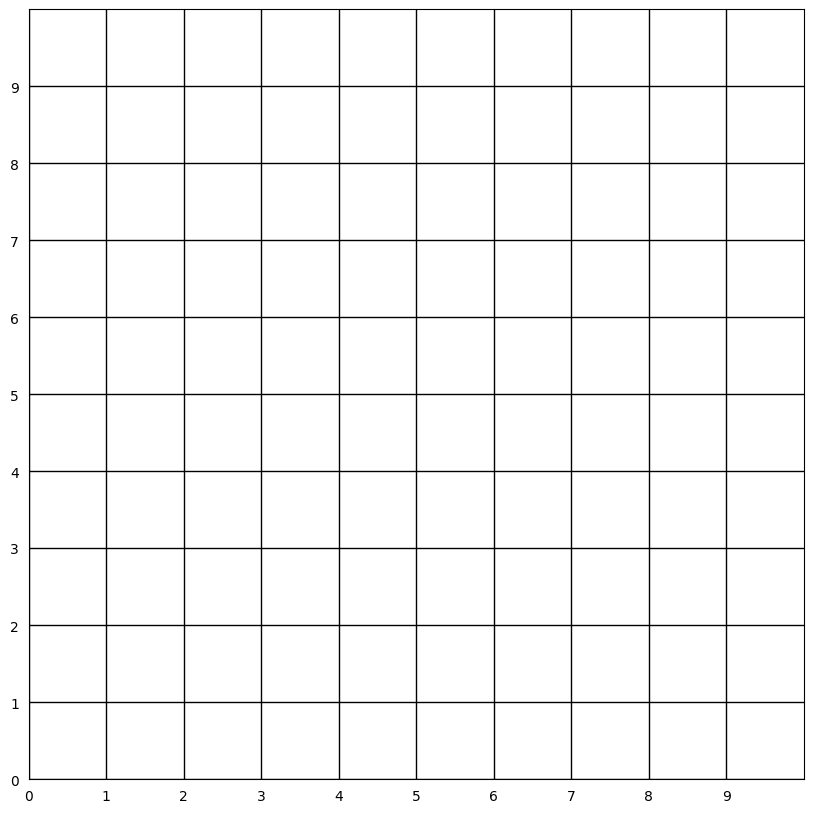

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.set_xlim((0, 10))
ax.set_ylim((0, 10))

# grid
ax.set_xticks(range(10))
ax.set_yticks(range(10))
row_labels = range(10)
col_labels = range(10)
plt.tick_params(labelbottom=col_labels, labelleft=row_labels)
plt.tick_params(color='white')
plt.grid(color='black', linestyle='-', linewidth=1)

def init():
    # initialize an empty list of cirlces
    return []

def animate(i):
    frame_patches = []
    # mapping status
    for j in range(i):
        m1 = patches.Rectangle(xy=(df['drone_1_y'][j], 9-df['drone_1_x'][j]), width=1, height=1, fc='lightblue')
        m2 = patches.Rectangle(xy=(df['drone_2_y'][j], 9-df['drone_2_x'][j]), width=1, height=1, fc='darkseagreen')
        frame_patches.append(ax.add_patch(m1))
        frame_patches.append(ax.add_patch(m2))

    # drones
    d1 = patches.Circle(xy=(df['drone_1_y'][i] + 0.25, 9-df['drone_1_x'][i] + 0.25), radius=0.125, fc='steelblue')
    d2 = patches.Circle(xy=(df['drone_2_y'][i] + 0.25, 9-df['drone_2_x'][i] + 0.25), radius=0.125, fc='darkolivegreen')
    m1 = patches.Rectangle(xy=(df['drone_1_y'][i], 9-df['drone_1_x'][i]), width=1, height=1, fc='lightblue')
    m2 = patches.Rectangle(xy=(df['drone_2_y'][i], 9-df['drone_2_x'][i]), width=1, height=1, fc='darkseagreen')
    frame_patches.append(ax.add_patch(m1))
    frame_patches.append(ax.add_patch(m2))
    frame_patches.append(ax.add_patch(d1))
    frame_patches.append(ax.add_patch(d2))

    return frame_patches

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=max_steps, interval=500, blit=True)

In [ ]:
anim

**3 drones**

In [ ]:
# ===================================================================================================
# Training: 1 drone
# ===================================================================================================

# records for each episode
time_steps = [] # number of time steps in total
epsilons = [] # epsilon at the end of each episode
greedy = [] # the ratio of greedy choices
coverage = [] # the ratio of visited cells at the end
speed = [] # number of time steps to cover decent amount of cells
sum_q_values = [] # sum of q-values
results_mapping = [] # mapping status
results_count = [] # count status
total_reward = []
total_action_values = []
total_greedy_action_values = []

q_class = []

coverage_threshold = 0.90
max_stuck = 100000

# parameters for training
train_episodes = 200000
max_steps = 10 * 10 * 2

# initialize the environment and the q tables
env = Grid(x_size=10, y_size=10, n_agents=2, fov_x=3, fov_y=3)
q = QTables(observation_space=env.observation_space, action_space=env.action_space, eps_start=1, eps_end=0, gamma=0.5, r=0.9999, lr=0.01)

# training
for episode in range(train_episodes):
    state = env.reset()
    state = [arr.astype('int') for arr in state] # convert from float to integer
    eps_tmp = q.eps

    greedy_count = [0] * env.n_agents
    coverage_track = True
    epi_reward = [0] * env.n_agents
    epi_action_value = [0] * env.n_agents
    epi_greedy_action_value = [0] * env.n_agents

    for step in range(max_steps):
        action_order = random.sample(env.idx_agents, env.n_agents) # return a random order of the drone indices
        for agent_i in action_order:
            action, greedy_tf, action_value = q.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
            next_state, reward, done = env.step(action, agent_i)
            next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
            q.train(state, next_state, action, reward, done, agent_i)

            epi_reward[agent_i] += reward
            greedy_count[agent_i] += greedy_tf * 1
            epi_action_value[agent_i] += action_value
            epi_greedy_action_value[agent_i] += action_value * greedy_tf

            if done:
                break

            # update the observation
            state = next_state

        # check if decent amoung of cells are visited
        current_coverage = env.get_coverage()
        if current_coverage >= coverage_threshold and coverage_track:
            speed.append(step)
            coverage_track = False

        # check if the task is completed
        if done:
            time_steps.append(step)
            break
        elif step == max_steps - 1:
            time_steps.append(step)
            if coverage_track:
                speed.append(np.nan)

    # record
    time_steps.append(step + 1)
    epsilons.append(eps_tmp)
    coverage.append(env.get_coverage())
    greedy.append(list(map(lambda x: x / (step + 1), greedy_count)))
    sum_q_values.append([q.q_tables[0].sum()])
    results_mapping.append(env.grid_status)
    results_count.append(env.grid_counts)
    total_reward.append(epi_reward)
    total_action_values.append(epi_action_value)
    total_greedy_action_values.append(epi_greedy_action_value)

    if episode % 1000 == 0:
        q_class.append(copy.deepcopy(q))

    # update epsilon
    q.update_eps()

    print('//Episode {0}//    Epsilon: {1:.3f},    Steps: {2},    Greedy Choices　(%): {3:.3f},    Coverage (%): {4:.3f},    Steps to Visit {5}% Cells: {6},    Sum of Q-Values: {7:.1f},    Total Reward: {8}'\
          .format(episode+1, eps_tmp, step+1, np.mean(greedy[episode]), coverage[episode], coverage_threshold * 100, speed[episode], sum_q_values[episode][0], np.mean(total_reward[episode])))

In [ ]:
q_last = copy.deepcopy(q)

In [ ]:
state = env.reset([[0, 0], [9, 9]])
state = [arr.astype('int') for arr in state] # convert from float to integer
q_last.eps = 0
trajectory_1 = [[0, 0]]
trajectory_2 = [[9, 9]]
reward_1 = []
reward_2 = []
action_1 = []
action_2 = []

for step in range(max_steps):
    action_order = [0, 1]
    for agent_i in action_order:
        action, greedy_tf, action_value = q_last.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
        next_state, reward, done = env.step(action, agent_i)
        next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
        if agent_i == 0:
            trajectory_1.append(copy.deepcopy(env.agent_pos[0]))
            reward_1.append(reward)
            action_1.append(action)
        else:
            trajectory_2.append(copy.deepcopy(env.agent_pos[1]))
            reward_2.append(reward)
            action_2.append(action)

        if done:
            break

        # update the observation
        state = next_state

    # check if the task is completed
    if done:
        break

print(step)

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.set_xlim((0, 6))
ax.set_ylim((0, 6))

# grid
ax.set_xticks(range(6))
ax.set_yticks(range(6))
plt.tick_params(labelbottom=False, labelleft=False)
plt.tick_params(color='white')
plt.grid(color='black', linestyle='-', linewidth=1)

def init():
    # initialize an empty list of cirlces
    return []

def animate(i):
    frame_patches = []
    # mapping status
    for j in range(i):
        m1 = patches.Rectangle(xy=(df['drone_1_y'][j], 5-df['drone_1_x'][j]), width=1, height=1, fc='lightblue')
        m2 = patches.Rectangle(xy=(df['drone_2_y'][j], 5-df['drone_2_x'][j]), width=1, height=1, fc='darkseagreen')
        frame_patches.append(ax.add_patch(m1))
        frame_patches.append(ax.add_patch(m2))

    # drones
    d1 = patches.Circle(xy=(df['drone_1_y'][i] + 0.25, 5-df['drone_1_x'][i] + 0.25), radius=0.125, fc='steelblue')
    d2 = patches.Circle(xy=(df['drone_2_y'][i] + 0.25, 5-df['drone_2_x'][i] + 0.25), radius=0.125, fc='darkolivegreen')
    frame_patches.append(ax.add_patch(d1))
    frame_patches.append(ax.add_patch(d2))

    return frame_patches

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=max_steps, interval=500, blit=True)

In [ ]:
anim

### **8 X 8 Grid**

**2 Drones**

In [ ]:
# ===================================================================================================
# Training: 1 drone
# ===================================================================================================

# records for each episode
time_steps = [] # number of time steps in total
epsilons = [] # epsilon at the end of each episode
greedy = [] # the ratio of greedy choices
coverage = [] # the ratio of visited cells at the end
speed = [] # number of time steps to cover decent amount of cells
sum_q_values = [] # sum of q-values
results_mapping = [] # mapping status
results_count = [] # count status
total_reward = []
total_action_values = []
total_greedy_action_values = []

q_class = []

coverage_threshold = 0.90
max_stuck = 100000

# parameters for training
train_episodes = 200000
max_steps = 10 * 10 * 2

# initialize the environment and the q tables
env = Grid(x_size=10, y_size=10, n_agents=2, fov_x=3, fov_y=3)
q = QTables(observation_space=env.observation_space, action_space=env.action_space, eps_start=1, eps_end=0, gamma=0.5, r=0.9999, lr=0.01)

# training
for episode in range(train_episodes):
    state = env.reset()
    state = [arr.astype('int') for arr in state] # convert from float to integer
    eps_tmp = q.eps

    greedy_count = [0] * env.n_agents
    coverage_track = True
    epi_reward = [0] * env.n_agents
    epi_action_value = [0] * env.n_agents
    epi_greedy_action_value = [0] * env.n_agents

    for step in range(max_steps):
        action_order = random.sample(env.idx_agents, env.n_agents) # return a random order of the drone indices
        for agent_i in action_order:
            action, greedy_tf, action_value = q.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
            next_state, reward, done = env.step(action, agent_i)
            next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
            q.train(state, next_state, action, reward, done, agent_i)

            epi_reward[agent_i] += reward
            greedy_count[agent_i] += greedy_tf * 1
            epi_action_value[agent_i] += action_value
            epi_greedy_action_value[agent_i] += action_value * greedy_tf

            if done:
                break

            # update the observation
            state = next_state

        # check if decent amoung of cells are visited
        current_coverage = env.get_coverage()
        if current_coverage >= coverage_threshold and coverage_track:
            speed.append(step)
            coverage_track = False

        # check if the task is completed
        if done:
            time_steps.append(step)
            break
        elif step == max_steps - 1:
            time_steps.append(step)
            if coverage_track:
                speed.append(np.nan)

    # record
    time_steps.append(step + 1)
    epsilons.append(eps_tmp)
    coverage.append(env.get_coverage())
    greedy.append(list(map(lambda x: x / (step + 1), greedy_count)))
    sum_q_values.append([q.q_tables[0].sum()])
    results_mapping.append(env.grid_status)
    results_count.append(env.grid_counts)
    total_reward.append(epi_reward)
    total_action_values.append(epi_action_value)
    total_greedy_action_values.append(epi_greedy_action_value)

    if episode % 1000 == 0:
        q_class.append(copy.deepcopy(q))

    # update epsilon
    q.update_eps()

    print('//Episode {0}//    Epsilon: {1:.3f},    Steps: {2},    Greedy Choices　(%): {3:.3f},    Coverage (%): {4:.3f},    Steps to Visit {5}% Cells: {6},    Sum of Q-Values: {7:.1f},    Total Reward: {8}'\
          .format(episode+1, eps_tmp, step+1, np.mean(greedy[episode]), coverage[episode], coverage_threshold * 100, speed[episode], sum_q_values[episode][0], np.mean(total_reward[episode])))

In [ ]:
q_last = copy.deepcopy(q)

In [ ]:
state = env.reset([[0, 0], [9, 9]])
state = [arr.astype('int') for arr in state] # convert from float to integer
q_last.eps = 0
trajectory_1 = [[0, 0]]
trajectory_2 = [[9, 9]]
reward_1 = []
reward_2 = []
action_1 = []
action_2 = []

for step in range(max_steps):
    action_order = [0, 1]
    for agent_i in action_order:
        action, greedy_tf, action_value = q_last.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
        next_state, reward, done = env.step(action, agent_i)
        next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
        if agent_i == 0:
            trajectory_1.append(copy.deepcopy(env.agent_pos[0]))
            reward_1.append(reward)
            action_1.append(action)
        else:
            trajectory_2.append(copy.deepcopy(env.agent_pos[1]))
            reward_2.append(reward)
            action_2.append(action)

        if done:
            break

        # update the observation
        state = next_state

    # check if the task is completed
    if done:
        break

print(step)

**3 Drones**

In [ ]:
# ===================================================================================================
# Training: 1 drone
# ===================================================================================================

# records for each episode
time_steps = [] # number of time steps in total
epsilons = [] # epsilon at the end of each episode
greedy = [] # the ratio of greedy choices
coverage = [] # the ratio of visited cells at the end
speed = [] # number of time steps to cover decent amount of cells
sum_q_values = [] # sum of q-values
results_mapping = [] # mapping status
results_count = [] # count status
total_reward = []
total_action_values = []
total_greedy_action_values = []

q_class = []

coverage_threshold = 0.90
max_stuck = 100000

# parameters for training
train_episodes = 200000
max_steps = 10 * 10 * 2

# initialize the environment and the q tables
env = Grid(x_size=10, y_size=10, n_agents=2, fov_x=3, fov_y=3)
q = QTables(observation_space=env.observation_space, action_space=env.action_space, eps_start=1, eps_end=0, gamma=0.5, r=0.9999, lr=0.01)

# training
for episode in range(train_episodes):
    state = env.reset()
    state = [arr.astype('int') for arr in state] # convert from float to integer
    eps_tmp = q.eps

    greedy_count = [0] * env.n_agents
    coverage_track = True
    epi_reward = [0] * env.n_agents
    epi_action_value = [0] * env.n_agents
    epi_greedy_action_value = [0] * env.n_agents

    for step in range(max_steps):
        action_order = random.sample(env.idx_agents, env.n_agents) # return a random order of the drone indices
        for agent_i in action_order:
            action, greedy_tf, action_value = q.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
            next_state, reward, done = env.step(action, agent_i)
            next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
            q.train(state, next_state, action, reward, done, agent_i)

            epi_reward[agent_i] += reward
            greedy_count[agent_i] += greedy_tf * 1
            epi_action_value[agent_i] += action_value
            epi_greedy_action_value[agent_i] += action_value * greedy_tf

            if done:
                break

            # update the observation
            state = next_state

        # check if decent amoung of cells are visited
        current_coverage = env.get_coverage()
        if current_coverage >= coverage_threshold and coverage_track:
            speed.append(step)
            coverage_track = False

        # check if the task is completed
        if done:
            time_steps.append(step)
            break
        elif step == max_steps - 1:
            time_steps.append(step)
            if coverage_track:
                speed.append(np.nan)

    # record
    time_steps.append(step + 1)
    epsilons.append(eps_tmp)
    coverage.append(env.get_coverage())
    greedy.append(list(map(lambda x: x / (step + 1), greedy_count)))
    sum_q_values.append([q.q_tables[0].sum()])
    results_mapping.append(env.grid_status)
    results_count.append(env.grid_counts)
    total_reward.append(epi_reward)
    total_action_values.append(epi_action_value)
    total_greedy_action_values.append(epi_greedy_action_value)

    if episode % 1000 == 0:
        q_class.append(copy.deepcopy(q))

    # update epsilon
    q.update_eps()

    print('//Episode {0}//    Epsilon: {1:.3f},    Steps: {2},    Greedy Choices　(%): {3:.3f},    Coverage (%): {4:.3f},    Steps to Visit {5}% Cells: {6},    Sum of Q-Values: {7:.1f},    Total Reward: {8}'\
          .format(episode+1, eps_tmp, step+1, np.mean(greedy[episode]), coverage[episode], coverage_threshold * 100, speed[episode], sum_q_values[episode][0], np.mean(total_reward[episode])))

In [ ]:
q_last = copy.deepcopy(q)

In [ ]:
state = env.reset([[0, 0], [9, 9]])
state = [arr.astype('int') for arr in state] # convert from float to integer
q_last.eps = 0
trajectory_1 = [[0, 0]]
trajectory_2 = [[9, 9]]
reward_1 = []
reward_2 = []
action_1 = []
action_2 = []

for step in range(max_steps):
    action_order = [0, 1]
    for agent_i in action_order:
        action, greedy_tf, action_value = q_last.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
        next_state, reward, done = env.step(action, agent_i)
        next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
        if agent_i == 0:
            trajectory_1.append(copy.deepcopy(env.agent_pos[0]))
            reward_1.append(reward)
            action_1.append(action)
        else:
            trajectory_2.append(copy.deepcopy(env.agent_pos[1]))
            reward_2.append(reward)
            action_2.append(action)

        if done:
            break

        # update the observation
        state = next_state

    # check if the task is completed
    if done:
        break

print(step)

## **10 X 10 Grid**

**2 Drones**

In [ ]:
# ===================================================================================================
# Training: 1 drone
# ===================================================================================================

# records for each episode
time_steps = [] # number of time steps in total
epsilons = [] # epsilon at the end of each episode
greedy = [] # the ratio of greedy choices
coverage = [] # the ratio of visited cells at the end
speed = [] # number of time steps to cover decent amount of cells
sum_q_values = [] # sum of q-values
results_mapping = [] # mapping status
results_count = [] # count status
total_reward = []
total_action_values = []
total_greedy_action_values = []

q_class = []

coverage_threshold = 0.90
max_stuck = 100000

# parameters for training
train_episodes = 200000
max_steps = 10 * 10 * 2

# initialize the environment and the q tables
env = Grid(x_size=10, y_size=10, n_agents=2, fov_x=3, fov_y=3)
q = QTables(observation_space=env.observation_space, action_space=env.action_space, eps_start=1, eps_end=0, gamma=0.5, r=0.9999, lr=0.01)

# training
for episode in range(train_episodes):
    state = env.reset()
    state = [arr.astype('int') for arr in state] # convert from float to integer
    eps_tmp = q.eps

    greedy_count = [0] * env.n_agents
    coverage_track = True
    epi_reward = [0] * env.n_agents
    epi_action_value = [0] * env.n_agents
    epi_greedy_action_value = [0] * env.n_agents

    for step in range(max_steps):
        action_order = random.sample(env.idx_agents, env.n_agents) # return a random order of the drone indices
        for agent_i in action_order:
            action, greedy_tf, action_value = q.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
            next_state, reward, done = env.step(action, agent_i)
            next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
            q.train(state, next_state, action, reward, done, agent_i)

            epi_reward[agent_i] += reward
            greedy_count[agent_i] += greedy_tf * 1
            epi_action_value[agent_i] += action_value
            epi_greedy_action_value[agent_i] += action_value * greedy_tf

            if done:
                break

            # update the observation
            state = next_state

        # check if decent amoung of cells are visited
        current_coverage = env.get_coverage()
        if current_coverage >= coverage_threshold and coverage_track:
            speed.append(step)
            coverage_track = False

        # check if the task is completed
        if done:
            time_steps.append(step)
            break
        elif step == max_steps - 1:
            time_steps.append(step)
            if coverage_track:
                speed.append(np.nan)

    # record
    time_steps.append(step + 1)
    epsilons.append(eps_tmp)
    coverage.append(env.get_coverage())
    greedy.append(list(map(lambda x: x / (step + 1), greedy_count)))
    sum_q_values.append([q.q_tables[0].sum()])
    results_mapping.append(env.grid_status)
    results_count.append(env.grid_counts)
    total_reward.append(epi_reward)
    total_action_values.append(epi_action_value)
    total_greedy_action_values.append(epi_greedy_action_value)

    if episode % 1000 == 0:
        q_class.append(copy.deepcopy(q))

    # update epsilon
    q.update_eps()

    print('//Episode {0}//    Epsilon: {1:.3f},    Steps: {2},    Greedy Choices　(%): {3:.3f},    Coverage (%): {4:.3f},    Steps to Visit {5}% Cells: {6},    Sum of Q-Values: {7:.1f},    Total Reward: {8}'\
          .format(episode+1, eps_tmp, step+1, np.mean(greedy[episode]), coverage[episode], coverage_threshold * 100, speed[episode], sum_q_values[episode][0], np.mean(total_reward[episode])))

In [ ]:
q_last = copy.deepcopy(q)

In [ ]:
state = env.reset([[0, 0], [9, 9]])
state = [arr.astype('int') for arr in state] # convert from float to integer
q_last.eps = 0
trajectory_1 = [[0, 0]]
trajectory_2 = [[9, 9]]
reward_1 = []
reward_2 = []
action_1 = []
action_2 = []

for step in range(max_steps):
    action_order = [0, 1]
    for agent_i in action_order:
        action, greedy_tf, action_value = q_last.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
        next_state, reward, done = env.step(action, agent_i)
        next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
        if agent_i == 0:
            trajectory_1.append(copy.deepcopy(env.agent_pos[0]))
            reward_1.append(reward)
            action_1.append(action)
        else:
            trajectory_2.append(copy.deepcopy(env.agent_pos[1]))
            reward_2.append(reward)
            action_2.append(action)

        if done:
            break

        # update the observation
        state = next_state

    # check if the task is completed
    if done:
        break

print(step)

**3 Drones**

In [ ]:
# ===================================================================================================
# Training: 1 drone
# ===================================================================================================

# records for each episode
time_steps = [] # number of time steps in total
epsilons = [] # epsilon at the end of each episode
greedy = [] # the ratio of greedy choices
coverage = [] # the ratio of visited cells at the end
speed = [] # number of time steps to cover decent amount of cells
sum_q_values = [] # sum of q-values
results_mapping = [] # mapping status
results_count = [] # count status
total_reward = []
total_action_values = []
total_greedy_action_values = []

q_class = []

coverage_threshold = 0.90
max_stuck = 100000

# parameters for training
train_episodes = 200000
max_steps = 10 * 10 * 2

# initialize the environment and the q tables
env = Grid(x_size=10, y_size=10, n_agents=2, fov_x=3, fov_y=3)
q = QTables(observation_space=env.observation_space, action_space=env.action_space, eps_start=1, eps_end=0, gamma=0.5, r=0.9999, lr=0.01)

# training
for episode in range(train_episodes):
    state = env.reset()
    state = [arr.astype('int') for arr in state] # convert from float to integer
    eps_tmp = q.eps

    greedy_count = [0] * env.n_agents
    coverage_track = True
    epi_reward = [0] * env.n_agents
    epi_action_value = [0] * env.n_agents
    epi_greedy_action_value = [0] * env.n_agents

    for step in range(max_steps):
        action_order = random.sample(env.idx_agents, env.n_agents) # return a random order of the drone indices
        for agent_i in action_order:
            action, greedy_tf, action_value = q.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
            next_state, reward, done = env.step(action, agent_i)
            next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
            q.train(state, next_state, action, reward, done, agent_i)

            epi_reward[agent_i] += reward
            greedy_count[agent_i] += greedy_tf * 1
            epi_action_value[agent_i] += action_value
            epi_greedy_action_value[agent_i] += action_value * greedy_tf

            if done:
                break

            # update the observation
            state = next_state

        # check if decent amoung of cells are visited
        current_coverage = env.get_coverage()
        if current_coverage >= coverage_threshold and coverage_track:
            speed.append(step)
            coverage_track = False

        # check if the task is completed
        if done:
            time_steps.append(step)
            break
        elif step == max_steps - 1:
            time_steps.append(step)
            if coverage_track:
                speed.append(np.nan)

    # record
    time_steps.append(step + 1)
    epsilons.append(eps_tmp)
    coverage.append(env.get_coverage())
    greedy.append(list(map(lambda x: x / (step + 1), greedy_count)))
    sum_q_values.append([q.q_tables[0].sum()])
    results_mapping.append(env.grid_status)
    results_count.append(env.grid_counts)
    total_reward.append(epi_reward)
    total_action_values.append(epi_action_value)
    total_greedy_action_values.append(epi_greedy_action_value)

    if episode % 1000 == 0:
        q_class.append(copy.deepcopy(q))

    # update epsilon
    q.update_eps()

    print('//Episode {0}//    Epsilon: {1:.3f},    Steps: {2},    Greedy Choices　(%): {3:.3f},    Coverage (%): {4:.3f},    Steps to Visit {5}% Cells: {6},    Sum of Q-Values: {7:.1f},    Total Reward: {8}'\
          .format(episode+1, eps_tmp, step+1, np.mean(greedy[episode]), coverage[episode], coverage_threshold * 100, speed[episode], sum_q_values[episode][0], np.mean(total_reward[episode])))

In [ ]:
q_last = copy.deepcopy(q)

In [ ]:
state = env.reset([[0, 0], [9, 9]])
state = [arr.astype('int') for arr in state] # convert from float to integer
q_last.eps = 0
trajectory_1 = [[0, 0]]
trajectory_2 = [[9, 9]]
reward_1 = []
reward_2 = []
action_1 = []
action_2 = []

for step in range(max_steps):
    action_order = [0, 1]
    for agent_i in action_order:
        action, greedy_tf, action_value = q_last.get_action(observations=state, agent_i=agent_i, stuck_counts=env.stuck_counts, max_stuck=max_stuck, e_greedy=True, softmax=False)
        next_state, reward, done = env.step(action, agent_i)
        next_state = [arr.astype('int') for arr in next_state] # convert from float to integer
        if agent_i == 0:
            trajectory_1.append(copy.deepcopy(env.agent_pos[0]))
            reward_1.append(reward)
            action_1.append(action)
        else:
            trajectory_2.append(copy.deepcopy(env.agent_pos[1]))
            reward_2.append(reward)
            action_2.append(action)

        if done:
            break

        # update the observation
        state = next_state

    # check if the task is completed
    if done:
        break

print(step)